# Trabajo Práctico 2: Análisis con Voting - Organización de Datos

# **Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [5]:
from funcionesAuxiliares import graficar_auc_roc
from funcionesAuxiliares import traer_df
from funcionesAuxiliares import graficar_matriz_confusion

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo. También segmentamos el dataset en X e y (target):

In [6]:
df = traer_df()
df = preparar_dataset(df)
X, y = dividir_dataset(df)
X = aplicar_one_hot_encoding(X)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Asignamos los clasificadores a ser utilizados para realizar el ensamble. En este caso, utilizamos los que mejor ROC-AUC score proporcionaron: KNN, SVM y Random Forest, cada uno con sus mejores hiperparámetros.

In [8]:
clf_1 = KNeighborsClassifier(n_neighbors = 60, weights = 'uniform', metric = 'minkowski')
clf_2 = SVC(C = 200, kernel = 'rbf', gamma = 0.1, probability = True)
clf_3 = RandomForestClassifier(max_depth = 17, n_estimators = 500, criterion = 'entropy')

## Entrenamiento y predicción con el dataset original


Generamos el ensamble con los modelos anteriormente mencionados:

In [9]:
stacking = StackingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], n_jobs = -1
)

Normalizamos los datos del dataset original y entrenamos el modelo:

In [10]:
X_train, X_test = normalizar_datos(X_train, X_test)
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('clf_1', KNeighborsClassifier(n_neighbors=60)),
                               ('clf_2',
                                SVC(C=200, gamma=0.1, probability=True)),
                               ('clf_3',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=17,
                                                       n_estimators=500))],
                   n_jobs=-1)

Ahora hacemos que este prediga sobre el subset de validation:

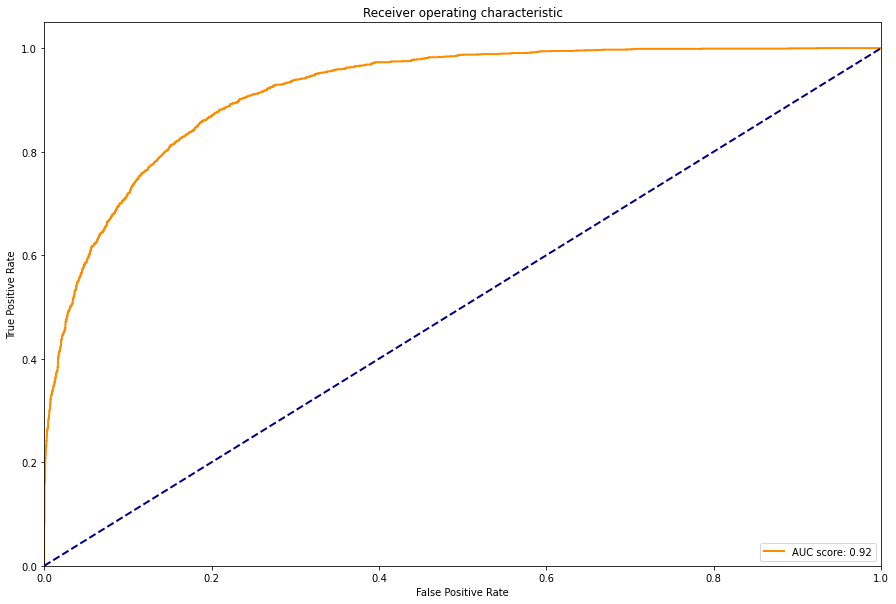

El valor de la metrica AUC-ROC para este modelo es: 0.9180062517520486


In [11]:
y_pred = stacking.predict(X_test)
y_pred_proba = stacking.predict_proba(X_test)[:,1]
graficar_auc_roc(y_test,y_pred_proba)

Podemos observar un AUC score bastante alto, aproximadamente de 0.92. Tiene sentido, pues estamos realizando un ensamble de los modelos que mejores resultados dieron.

Imprimimos el classification report:

In [12]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'], digits = 3))


                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.884     0.944     0.913      6159
   Tiene Alto Valor Adquisitivo      0.778     0.614     0.686      1982

                       accuracy                          0.863      8141
                      macro avg      0.831     0.779     0.800      8141
                   weighted avg      0.858     0.863     0.858      8141



Podemos ver que los valores de precision y recall para las instancias con pocos ingresos son muy elevados. Por otra parte, las instancias con alto valor adquisitivo son predichas con una precision relativamente alta, pero un recall regular. Se podría decir que al Stacking le cuesta más clasificar estas últimas. Esto se ve más claramente en la siguiente matriz de confusión:

In [13]:
from funcionesAuxiliares import graficar_matriz_confusion

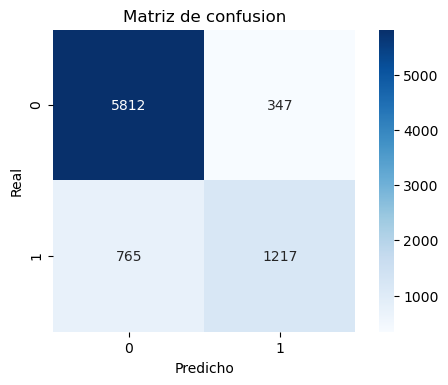

In [14]:
graficar_matriz_confusion(y_test, y_pred)

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [15]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [16]:
X_exp = expandir_dataset(X)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Generamos el ensamble para el dataset expandido con los modelos anteriormente mencionados:

In [17]:
stacking_expandido = StackingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], n_jobs = -1
)

Normalizamos los datos del dataset ampliado y entrenamos el modelo:

In [18]:
X_exp_train, X_exp_test = normalizar_datos(X_exp_train, X_exp_test)
stacking_expandido.fit(X_exp_train, y_exp_train)

StackingClassifier(estimators=[('clf_1', KNeighborsClassifier(n_neighbors=60)),
                               ('clf_2',
                                SVC(C=200, gamma=0.1, probability=True)),
                               ('clf_3',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=17,
                                                       n_estimators=500))],
                   n_jobs=-1)

Ahora hacemos que este prediga sobre el subset de validation:

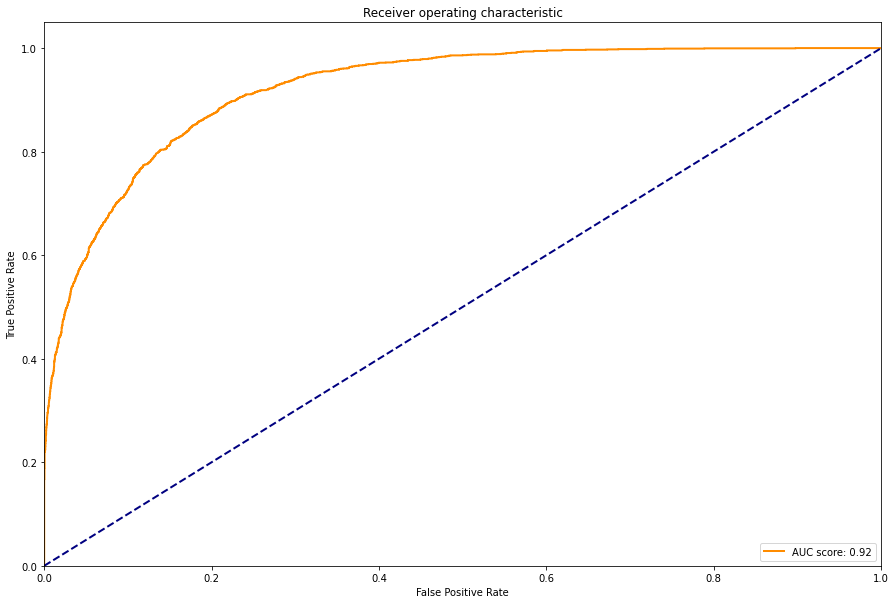

El valor de la metrica AUC-ROC para este modelo es: 0.9211136959375735


In [19]:
y_pred = stacking_expandido.predict(X_exp_test)
y_pred_proba = stacking_expandido.predict_proba(X_exp_test)[:,1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos observar un AUC score levemente superior al del Stacking con el dataset original. A continuación, vemos el classification report:

In [20]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'], digits = 3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.885     0.946     0.914      6159
   Tiene Alto Valor Adquisitivo      0.785     0.617     0.691      1982

                       accuracy                          0.865      8141
                      macro avg      0.835     0.781     0.802      8141
                   weighted avg      0.860     0.865     0.860      8141



Se ve una muy leve mejora en el recall para las instancias que poseen alto valor adquisitivo. Es decir, estas instancias fueron mejor clasificadas según el target. Esto se ve en la matriz de confusión:

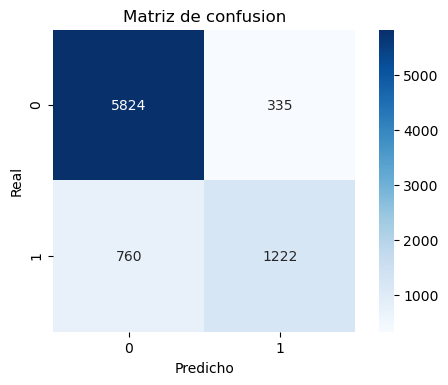

In [21]:
graficar_matriz_confusion(y_test, y_pred)

## Predicción con el dataset de test holdout
A continuación, realizamos la predicción con Stacking sin expandir el dataset sobre el dataset de holdout, y la escribimos al archivo 'Stacking.csv'

In [22]:
from funcionesAuxiliares import traer_holdout
from preprocessing import preparar_holdout
from preprocessing import normalizar_holdout
from funcionesAuxiliares import escribir_predicciones

In [23]:
holdout = traer_holdout()
ids, holdout = preparar_holdout(holdout)
holdout = aplicar_one_hot_encoding(holdout)
holdout = normalizar_holdout(holdout)

In [24]:
predicciones = stacking.predict(holdout)
escribir_predicciones(ids, predicciones, "Stacking")